# Aula 8 - Calssificação Bayesiana

Vamos inicialmente ler os dados:

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
random.seed(42) # define the seed (important to reproduce the results)

#data = pd.read_csv('data/vertebralcolumn-3C.csv', header=(0))
#data = pd.read_csv('data/BreastCancer.csv', header=(0))
#data = pd.read_csv('data/Iris.csv', header=(0))
data = pd.read_csv('/home/edmurcn/Documentos/MeusProjetos/Fis._Estat._Comp./Intro._Ciencia_Dados/data/Vehicle.csv', header=(0))
#data = pd.read_csv('data/winequality-red.csv', header=(0))

data = data.dropna(axis='rows') #remove NaN
# armazena os nomes das classes

nrow, ncol = data.shape
print("Matriz de atributos: Número de linhas:", nrow, " colunas: ", ncol)
attributes = list(data.columns)
data.head(10)

Matriz de atributos: Número de linhas: 846  colunas:  19


,Comp,Circ,D.Circ,Rad.Ra,Pr.Axis.Ra,Max.L.Ra,Scat.Ra,Elong,Pr.Axis.Rect,Max.L.Rect,Sc.Var.Maxis,Sc.Var.maxis,Ra.Gyr,Skew.Maxis,Skew.maxis,Kurt.maxis,Kurt.Maxis,Holl.Ra,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
5,107,57,106,172,50,6,255,26,28,169,280,957,264,85,5,9,181,183,bus
6,97,43,73,173,65,6,153,42,19,143,176,361,172,66,13,1,200,204,bus
7,90,43,66,157,65,9,137,48,18,146,162,281,164,67,3,3,193,202,van
8,86,34,62,140,61,7,122,54,17,127,141,223,112,64,2,14,200,208,van
9,93,44,98,197,62,11,183,36,22,146,202,505,152,64,4,14,195,204,saab


Vamos construir as variáveis $X$ e $y$, sendo que o processo classificação se resume em estimar a função $f$ na relação $y = f(X) + \epsilon$, onde $\epsilon$ é o erro, que tem distribuição normal com média igual a zero e variância $\sigma^{2}$. Convertemos os dados para o formato Numpy para facilitar a sua manipulação.

In [3]:
y = data.iloc[:,-1]
classes = np.array(pd.unique(y))
data = data.to_numpy()
nrow,ncol = data.shape
X = data[:,0:ncol-1]

Para treinar o classificador, precisamos definir o conjunto de teste e treinamento.

In [4]:
from sklearn.model_selection import train_test_split
p = 0.7 # fracao de elementos no conjunto de treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

A partir desse conjunto de dados, podemos realizar a classificação.

# Classificador Bayesiano
Vamos considerar o caso paramétrico, assumindo que cada variável está distribuída de acordo com uma distribuição Normal. Outras distribuições também podem ser utilizadas.

Já selecionamos os conjuntos de treinamento e teste anteriormente. No conjunto de treinamento, vamos calcular a média e desvio padrão de cada atributo para cada classe. A seguir, reaizamos a classificação, dos dados usando a teoria da decisão Bayesiana, isto é: $X \Epsilon C_i$ se, e somente se, $P(C_i|X) = máx \; P(C_j|X)$ para todo 
j
.



In [5]:
from scipy.stats import multivariate_normal

#matrix to store the probabilities
P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) #fraction of elements in each class
for i in np.arange(0, len(classes)):
    elements = np.array(np.where(y_train == classes[i]))
    Pc[i] = elements.shape[1]/len(y_train)
    Z = X_train[elements,:][0].astype(float)
    m = np.mean(Z, axis = 0)
    cv = np.cov(np.transpose(Z))
    for j in np.arange(0,X_test.shape[0]):
        x = X_test[j,:]
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P[classes[i]][j] = pj*Pc[i]

In [6]:
print(P)

              van          saab           bus          opel
0    3.151847e-31  9.858817e-33  3.543175e-22  2.008144e-31
1    6.312434e-22  8.955506e-55  3.281194e-42  8.854235e-50
2    9.549453e-27  5.676222e-27  2.992373e-21  5.149165e-27
3    9.547932e-24  1.721556e-22  8.561567e-31  1.066572e-23
4    1.378438e-24  1.437899e-23  1.577016e-19  2.212885e-22
..            ...           ...           ...           ...
249  0.000000e+00  3.956652e-48  1.151983e-24  4.088737e-38
250  9.983964e-41  1.042205e-27  1.593905e-21  1.251171e-26
251  3.347217e-26  9.737831e-25  9.084512e-27  2.271166e-23
252  9.126644e-31  7.769182e-21  8.030936e-30  4.552604e-21
253  2.841329e-20  4.741875e-45  1.377657e-43  4.032846e-40

[254 rows x 4 columns]


Classifica de acordo com a classe mais provável:



In [7]:
y_pred = []
#np.array(test_x.shape[0], dtype=str)
for i in np.arange(0, X_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred)
y_test = np.array(y_test)
print(y_pred)

['bus' 'van' 'bus' 'saab' 'bus' 'van' 'van' 'saab' 'bus' 'saab' 'saab'
 'bus' 'van' 'opel' 'opel' 'van' 'saab' 'bus' 'saab' 'opel' 'van' 'van'
 'opel' 'opel' 'opel' 'saab' 'opel' 'van' 'van' 'van' 'opel' 'van' 'bus'
 'van' 'van' 'bus' 'bus' 'saab' 'bus' 'opel' 'van' 'bus' 'opel' 'van'
 'saab' 'saab' 'bus' 'van' 'bus' 'van' 'bus' 'bus' 'van' 'saab' 'bus'
 'opel' 'saab' 'opel' 'saab' 'saab' 'bus' 'van' 'saab' 'bus' 'bus' 'bus'
 'saab' 'saab' 'opel' 'opel' 'saab' 'bus' 'saab' 'bus' 'van' 'van' 'saab'
 'opel' 'saab' 'van' 'bus' 'van' 'saab' 'saab' 'opel' 'saab' 'van' 'bus'
 'van' 'saab' 'saab' 'opel' 'bus' 'bus' 'opel' 'bus' 'van' 'van' 'bus'
 'opel' 'saab' 'saab' 'opel' 'van' 'bus' 'bus' 'saab' 'van' 'saab' 'opel'
 'van' 'bus' 'van' 'bus' 'bus' 'van' 'bus' 'opel' 'bus' 'saab' 'bus'
 'opel' 'saab' 'van' 'bus' 'saab' 'bus' 'van' 'bus' 'saab' 'bus' 'van'
 'bus' 'saab' 'bus' 'bus' 'bus' 'saab' 'opel' 'bus' 'van' 'saab' 'bus'
 'bus' 'van' 'opel' 'saab' 'opel' 'van' 'saab' 'opel' 'bus' 'bus' 's

In [8]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.8937007874015748


Caso não paramétrico
Para o caso unidimensional, seja $X_1, X_2, ..., X_n$ uma amostra aleatória unidimensional identicamente distribuída de acordo com alguma função de distribuição $f$ não conhecida. Para estimarmos o formato de $f$ , usamos um estimador (kernel density estimator): 

$\hat f_x (x) = \frac{1}{n} \sum_{i=1}^{n} K_h (x - x_i) = \frac{1}{nh} \sum_{i=1}^{n} K \frac{(x - x_i)}{h}$ (1)
 
onde 
K
 é a função kernel. A estimação depende do parâmetro 
h
, que é um parâmetro livre e controla a abertura da função.

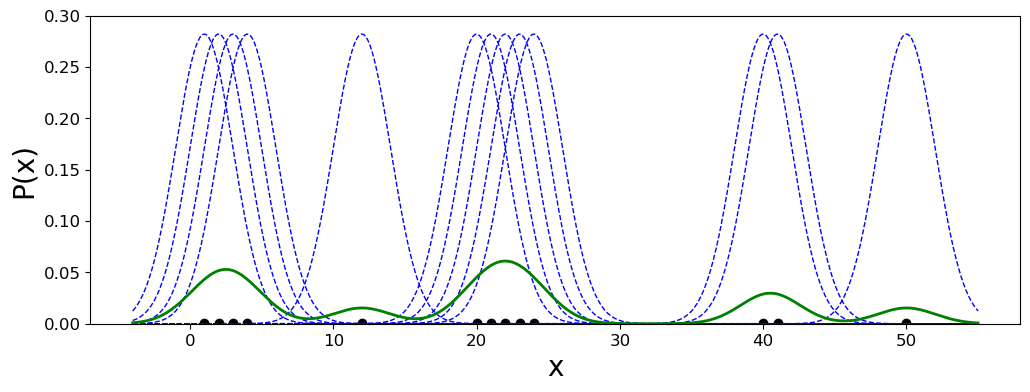

In [9]:
import numpy as np
import matplotlib.pyplot as plt

N = 20
# gera os dados
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))
# mostra os dados
plt.figure(figsize=(12,4))
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')

# valores x para serem usados nas densidades
X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]

h=2
fhat = 0 # estimacao obtida
for x in X:
    # distribuição normal centrada em x
    f = (1/np.sqrt(2*np.pi*h))*np.exp(-((X_plot - x)**2)/(2*h**2))
    fhat = fhat + f # acumula as distribuições
    plt.plot(X_plot,f, '--', color = 'blue', linewidth=1)

# mostra a distribuição estimada
plt.plot(X_plot,fhat/(len(X)*np.sqrt(h)), color = 'green', linewidth=2)
plt.xlabel('x', fontsize = 20)
plt.ylabel('P(x)', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim((0, 0.3))
plt.savefig('kernel-ex.eps')
plt.show(True)

Esse resultado pode ser obtido usando-se a função KernelDensity scikit-learn.

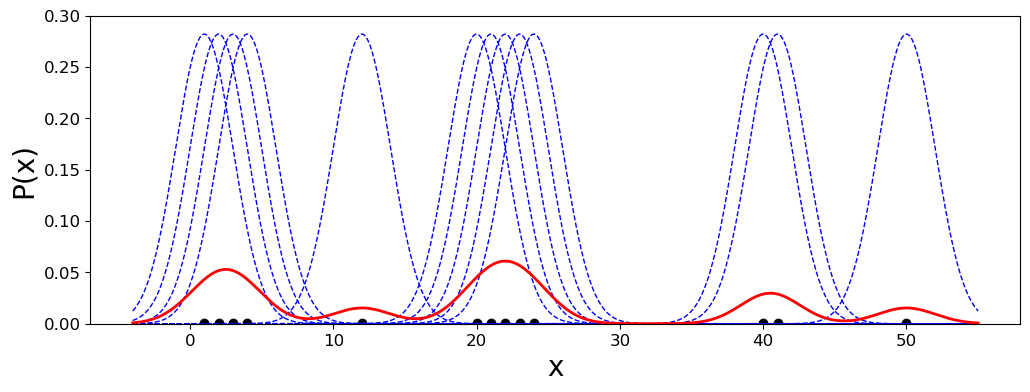

In [10]:
import numpy as np
from matplotlib.pyplot import cm
from sklearn.neighbors import KernelDensity

color=['red', 'blue', 'magenta', 'gray', 'green']

N = 20
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))

plt.figure(figsize=(12,4))
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')

X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]

h=2
fhat = 0
for x in X:
    f = (1/np.sqrt(2*np.pi*h))*np.exp(-((X_plot - x)**2)/(2*h**2))
    fhat = fhat + f
    plt.plot(X_plot,f, '--', color = 'blue', linewidth=1)

kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X)
log_dens = np.exp(kde.score_samples(X_plot)) # score_samples() returns the log density.
plt.plot(X_plot,log_dens, color = 'red', linewidth=2, label = 'h='+str(h))    
plt.xlabel('x', fontsize = 20)
plt.ylabel('P(x)', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim((0, 0.3))

plt.show(True)

Notem que o formato da estimação depende do parâmetro livre 
h
.

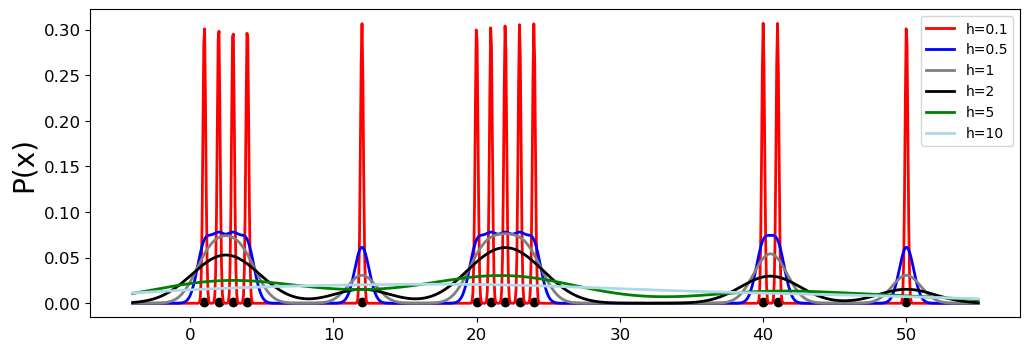

In [11]:
import numpy as np
from matplotlib.pyplot import cm

color=['red', 'blue', 'gray', 'black', 'green', 'lightblue']

N = 20
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))

X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]

plt.figure(figsize=(12,4))
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')
c = 0
vh = [0.1, 0.5, 1, 2, 5, 10]
for h in vh:
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X)
    log_dens = np.exp(kde.score_samples(X_plot)) # score_samples() returns the log density.
    plt.plot(X_plot,log_dens, color = color[c], linewidth=2, label = 'h='+str(h))
    c = c + 1
plt.ylabel('P(x)', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim((0, 0.2))
plt.legend(fontsize = 10)
#plt.savefig('kernel.eps')
plt.show(True)

Notem que a estimação é relacionada com a estimação usando-se histogramas.



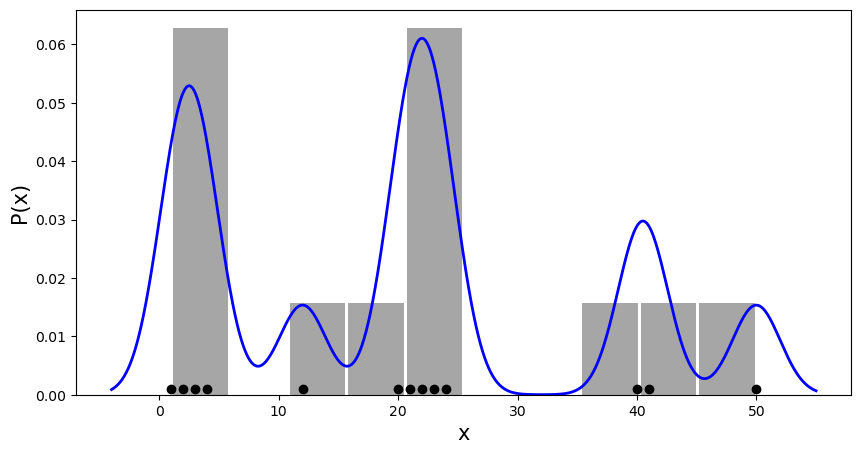

In [12]:
import numpy as np

N = 20
X = np.array([1, 2, 3, 4, 12, 20,21,22,23,24,40,41, 50])
X = X.reshape((len(X), 1))

plt.figure(figsize=(10,5))
# Histogram
nbins = 10
plt.hist(X,bins = nbins, density = True, color='gray',alpha=0.7, rwidth=0.95)

#Kernel density estimation
X_plot = np.linspace(np.min(X)-5, np.max(X)+5, 1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(X)
log_dens = np.exp(kde.score_samples(X_plot)) # score_samples() returns the log density.
plt.plot(X_plot,log_dens, color = 'blue', linewidth=2)
plt.plot(X[:, 0], 0.001*np.ones(X.shape[0]), 'ok')
plt.xlabel('x', fontsize = 15)
plt.ylabel('P(x)', fontsize = 15)

plt.show(True)

Usando o método kernel density estimation, podemos realizar a classificação.

In [14]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score

random.seed(42)
#data = pd.read_csv('data/Iris.csv', header=(0))
data = pd.read_csv('/home/edmurcn/Documentos/MeusProjetos/Fis._Estat._Comp./Intro._Ciencia_Dados/data/Vehicle.csv', header=(0))

classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

# Converte para matriz e vetor do numpy
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

# Seleciona os conjuntos de treinamento e teste
p = 0.8 # fraction of elements in the training set
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

# Matriz que armazena as probabilidades para cada classe
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe
h = 2
for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0].astype(float) # Elementos no conjunto de treinamento
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
    for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
        x = x_test[j,:]
        x = x.reshape((1,len(x)))
        # calcula a probabilidade pertencer a cada classe
        pj = np.exp(kde.score_samples(x)) 
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = [] # Vetor com as classes preditas
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=str)
# calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Acuracia:', score)

Acuracia: 0.6294117647058823


Notem que a acurácia depende do parâmetro 
h
, conforme verficamos abaixo.



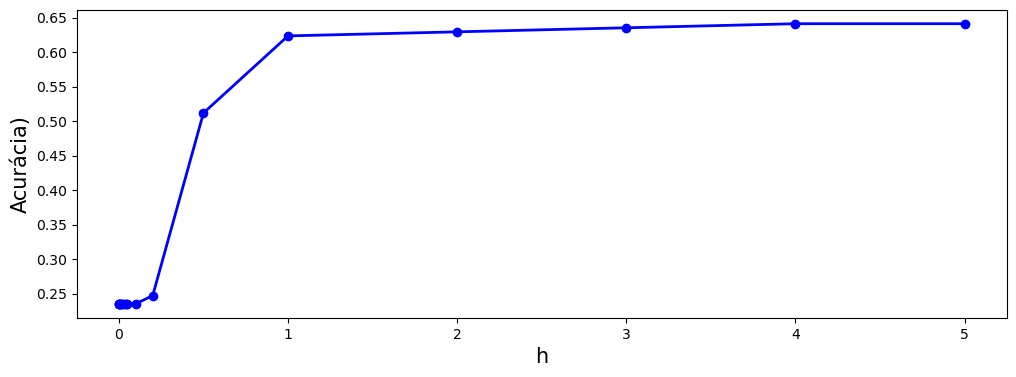

In [15]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

random.seed(42) 

#data = pd.read_csv('data/Iris.csv', header=(0))
data = pd.read_csv('/home/edmurcn/Documentos/MeusProjetos/Fis._Estat._Comp./Intro._Ciencia_Dados/data/Vehicle.csv', header=(0))

classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

# Converte para matriz e vetor do numpy
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

# Seleciona os conjuntos de treinamento e teste
p = 0.8 # fraction of elements in the test set
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

####  Realiza a classificacao ####
vacc = []
vh = [0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.04, 0.05, 0.1, 0.2, 0.5, 1, 2,3,4, 5]
plt.figure(figsize=(12,4))
for h in vh:
    # Matriz que armazena as probabilidades para cada classe
    P = pd.DataFrame(data=np.zeros((x_train.shape[0], len(classes))), columns = classes) 
    Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe
    for i in np.arange(0, len(classes)): # Para cada classe
        elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
        Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
        Z = x_train[elements,:][0].astype(float) # Elementos no conjunto de treinamento
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
        for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
            x = x_test[j,:]
            x = x.reshape((1,len(x)))
            # calcula a probabilidade pertencer a cada classe
            pj = np.exp(kde.score_samples(x)) 
            P[classes[i]][j] = pj*Pc[i]

    y_pred = [] # Vetor com as classes preditas
    for i in np.arange(0, x_test.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(classes[c])
    y_pred = np.array(y_pred, dtype=str)
    # calcula a acuracia
    score = accuracy_score(y_pred, y_test)
    vacc.append(score)
    #print('Acuracia:', score)
    
plt.plot(vh,vacc, 'o-', color = 'blue', linewidth=2)
plt.xlabel('h', fontsize = 15)
plt.ylabel('Acurácia)', fontsize = 15)
plt.show(True)

# Naive Bayes
No classificador Naive Bayes, podemos assumir que os atributos são normalmente distribuídos.

Lendo os dados novamente para evitar que alguma transformação anterior afete os resultados.

In [2]:
import random
random.seed(42) # define the seed (important to reproduce the results)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#data = pd.read_csv('data/vertebralcolumn-3C.csv', header=(0))
data = pd.read_csv('/home/edmurcn/Documentos/MeusProjetos/Fis._Estat._Comp./Intro._Ciencia_Dados/data/winequality-red.csv', header=(0))

data = data.dropna(axis='rows') #remove NaN
# armazena os nomes das classes
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

print("Número de linhas e colunas na matriz de atributos:", data.shape)
attributes = list(data.columns)
data.head(10)

Número de linhas e colunas na matriz de atributos: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [3]:
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

In [4]:
from sklearn.model_selection import train_test_split
p = 0.2 # fraction of elements in the training set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = 42)


In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

model = GaussianNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('Accuracy: ', model.score(x_test, y_test))

Accuracy:  0.55


Outra maneira de efetuarmos a classificação é assumirmos que os atributos possuem distribuição diferente da normal.

Uma possibilidade é assumirmos que os dados possuem distribuição de Bernoulli.



In [6]:
from sklearn.naive_bayes import BernoulliNB
# Usamos a função BernoulliNB para realizar a classificação usando a distribuição de Bernoulli
model = BernoulliNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('Accuracy: ', model.score(x_test, y_test))


Accuracy:  0.40625


# Região de decisão
Selecionando dois atributos, podemos visualizar a região de decisão. Para graficar a região de separação, precisamos instalar a bibliteca mlxtend: http://rasbt.github.io/mlxtend/installation/
Pode ser usado: conda install -c conda-forge mlxtend

Para o classificador Naive Bayes:

In [7]:
from mlxtend.plotting import plot_decision_regions
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
import sklearn.datasets as skdata
from matplotlib import pyplot
from pandas import DataFrame

# Gera os dados em duas dimensões
n_samples = 100 # número de observações
# centro dos grupos
centers = [(-4, 0), (0, 0), (3, 3)]
X, y = skdata.make_blobs(n_samples=100, n_features=2, cluster_std=1.0, centers=centers, 
                         shuffle=False, random_state=42)

# monta a matrix de atributos
d = np.column_stack((X,np.transpose(y)))
# converte para o formato dataframe do Pandas
data = DataFrame(data = d, columns=['X1', 'X2', 'y'])
features_names = ['X1', 'X2']
class_labels = np.unique(y)

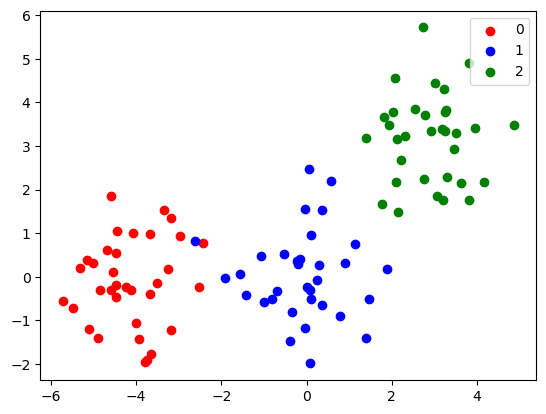

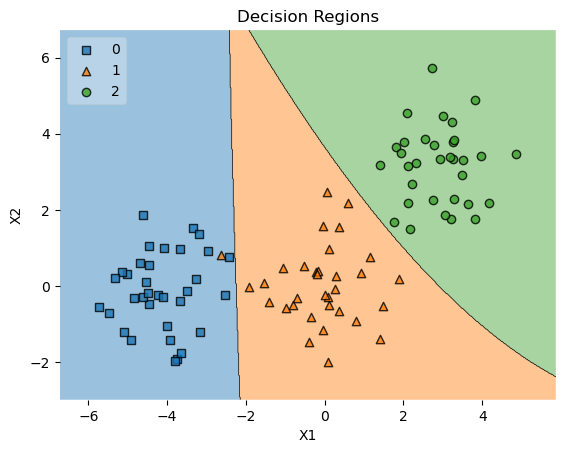

In [8]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB


# mostra os dados e colori de acordo com as classes
colors = ['red', 'blue', 'green', 'black']
aux = 0
for c in class_labels:
    ind = np.where(y == c)
    plt.scatter(X[ind,0][0], X[ind,1][0], color = colors[aux], label = c)
    aux = aux + 1
plt.legend()
plt.show()

# Training a classifier
model = GaussianNB()
model.fit(X, y)

# Plotting decision regions
plot_decision_regions(X, y, clf=model, legend=2)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Regions')
plt.show()